In [14]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
g = torch.Generator().manual_seed(2147483647)

In [8]:
# read the file
dialogues = open('Shakespeare-2.txt','r').read().lower()

chars = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

cleanDialogues =""
for char in dialogues:
  if char in chars or char == '\n' or char == ' ':
    cleanDialogues += char

dialogues = cleanDialogues.split('\n\n')
# only select the dialogues
for i in range(len(dialogues)):
  dialogues[i] = ' '.join(dialogues[i].split('\n')[1:])

## Create a vocabulary.

In [12]:
# create a vocabulary
words = sorted(list(set(' '.join(dialogues).split(' '))))
wtoi = {w: i+1 for i,w in enumerate(words)}
wtoi['...'] = 0
itow = {i:w for w,i in wtoi.items()}
vocab_size = len(itow)

block_size = 3

## Build the dataset

In [15]:
def build_dataset(dialogue):

  X,Y = [],[]

  for d in dialogue:

    context = [0]*block_size

    for word in d.split(' ') + ['...']:
      ix = wtoi[word]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  return X,Y

import random
random.seed(42)
random.shuffle(dialogues) #randomly shuffle the words
n1 = int(0.8 * len(dialogues))
n2 = int(0.9 * len(dialogues))

Xtr, Ytr = build_dataset(dialogues[:n1])       #80%
Xdev, Ydev = build_dataset(dialogues[n1:n2])   #10%
Xte, Yte = build_dataset(dialogues[n2:])       #10%

# visulaize first 10 training examples
for i in range(10):
  print(' '.join(itow[ix.item()] for ix in Xtr[i]), '--->',itow[Ytr[i].item()])

... ... ... ---> the
... ... the ---> date
... the date ---> is
the date is ---> out
date is out ---> of
is out of ---> such
out of such ---> prolixity
of such prolixity ---> well
such prolixity well ---> have
prolixity well have ---> no


## Define basic modules

In [16]:
class Linear:
  def __init__(self, fan_in, fan_out, bias = True):
    self.weight = torch.randn((fan_in,fan_out), generator = g)/ fan_in**0.5
    self.bias = torch.zeros((fan_out)) if bias else None
  def __call__(self,x):
    self.out =  x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

In [17]:
class BatchNorm1D:

  def __init__(self, dim, eps = 1e-5, momentum = 0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True

    # Parameters (Trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)

    # buffers (Trained with running momentum update)
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    if self.training:
      xmean = x.mean(0, keepdim = True)  # batch mean
      xvar = x.var(0, keepdim = True, unbiased = True)  # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var

    xhat = (x - xmean)/torch.sqrt(xvar - self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta

    # update the buffers

    if self.training:
      with torch.no_grad():
        self.running_mean = (1-self.momentum) *self.running_mean + self.momentum* xmean
        self.running_var = (1-self.momentum) *self.running_var + self.momentum* xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

In [18]:
class Tanh:
  def __call__(self,x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

## Initialize the neural network

In [19]:
n_embed = 5 # dimension of the character embedding
n_hidden = 100 # number of hidden neurons in a layer
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size,n_embed),      generator = g)
layers = [
    Linear(n_embed*block_size, n_hidden), BatchNorm1D(n_hidden), Tanh(),
    Linear(          n_hidden, n_hidden), BatchNorm1D(n_hidden), Tanh(),
    Linear(          n_hidden, n_hidden), BatchNorm1D(n_hidden), Tanh(),
    Linear(          n_hidden, n_hidden), BatchNorm1D(n_hidden), Tanh(),
    Linear(          n_hidden, n_hidden), BatchNorm1D(n_hidden), Tanh(),
    Linear(          n_hidden, vocab_size), BatchNorm1D(vocab_size),
]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  # apply gain to other layers
  for layer in layers[:-1]:
    if isinstance(layer,Linear):
      layer.weight *= 5/3

parameters = [C]+ [p for layer in layers for p in layer.parameters()]

print(sum(p.nelement() for p in parameters))

for p in parameters:
  p.requires_grad = True

1428208


## Run mini-batch gradient descent

In [20]:
# optimization
max_steps = 300
batch_size = 100
lossi = []
ud = []

for i in range(max_steps):

  #mini batch construct
  ix = torch.randint(0,Xtr.shape[0],(batch_size,))
  Xb , Yb = Xtr[ix] , Ytr[ix]

  #forward pass
  emb = C[Xb]
  x = emb.view(emb.shape[0],-1) # concatenate
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x,Yb) # cross entropy loss

  #backward pass
  for layer in layers:
    layer.out.retain_grad()
  for p in parameters:
    p.grad = None
  loss.backward()

  #update
  lr = 5.0
  for p in parameters:
    p.data += -lr*p.grad

  if i%20 ==0:
    print(f"{i:7d}/ {max_steps:7d}: {loss.item():.4f}")

  lossi.append(loss.log10().item())

  with torch.no_grad():
    ud.append([((lr*p.grad.std())/p.data.std()).log10().item() for p in parameters])


      0/     300: 9.4730
     20/     300: 8.9194
     40/     300: 8.1655
     60/     300: 7.6342
     80/     300: 7.5403
    100/     300: 7.7358
    120/     300: 8.0445
    140/     300: 7.2905
    160/     300: 6.9793
    180/     300: 7.0411
    200/     300: 7.2650
    220/     300: 7.1848
    240/     300: 6.9724
    260/     300: 7.1568
    280/     300: 7.2338


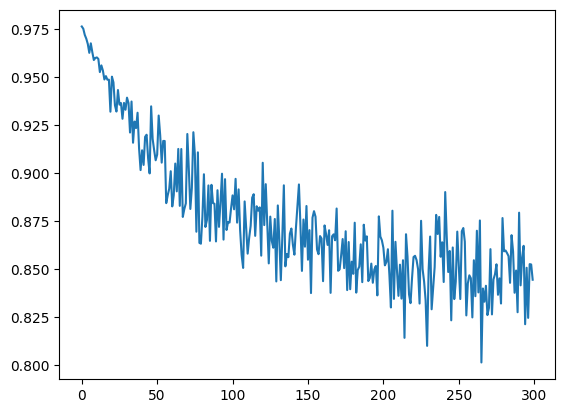

In [21]:
plt.plot(lossi)

layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 3.90%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 3.15%
layer 8 (      Tanh): mean +0.00, std 0.64, saturated: 2.57%
layer 11 (      Tanh): mean -0.00, std 0.65, saturated: 2.26%
layer 14 (      Tanh): mean -0.01, std 0.64, saturated: 1.61%


Text(0.5, 1.0, 'activation distribution')

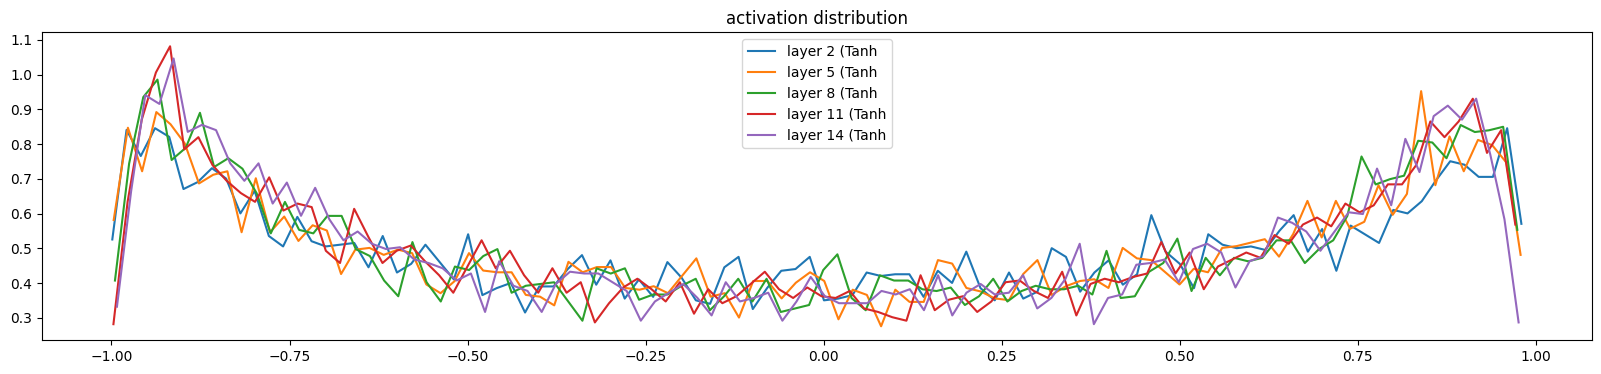

In [22]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.000000, std 2.779159e-04
layer 5 (      Tanh): mean +0.000000, std 2.313534e-04
layer 8 (      Tanh): mean -0.000000, std 2.378448e-04
layer 11 (      Tanh): mean -0.000000, std 2.617503e-04
layer 14 (      Tanh): mean -0.000000, std 3.997266e-04


Text(0.5, 1.0, 'gradient distribution')

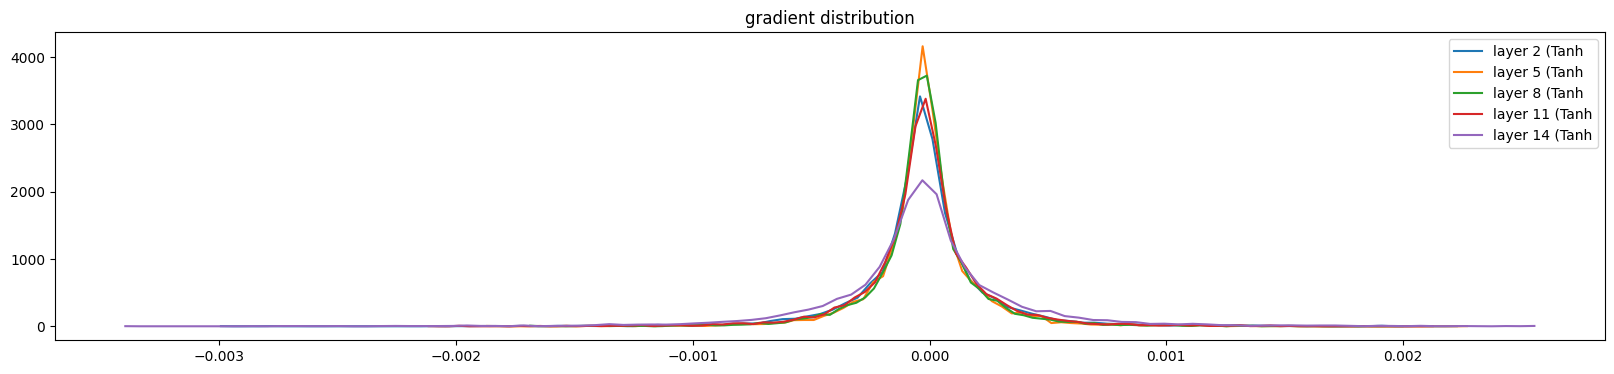

In [23]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

## Update-to-data ratio
This is used to manually find the best learning rate

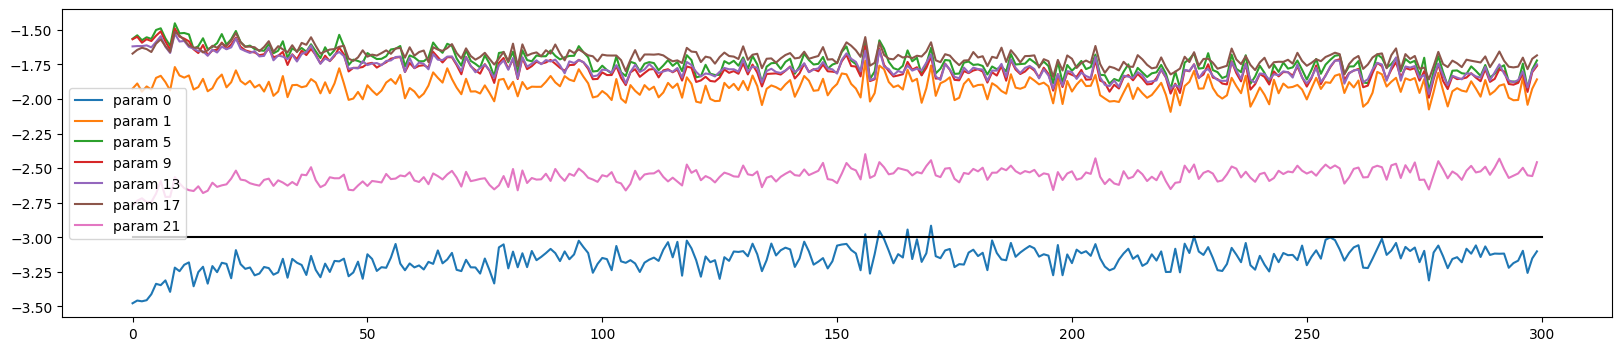

In [24]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

##Sampling Time!

In [25]:
for i in range(3):
  out = []
  context = [0]*block_size
  while True:
    emb = C[torch.tensor([context])]
    x = emb.view(emb.shape[0],-1) # concatenate
    for layer in layers:
      if isinstance(layer, BatchNorm1D):
        layer.training = False
    for layer in layers:
      x = layer(x)
    probs = torch.softmax(x, dim = 1)
    ix = torch.multinomial(probs, num_samples=1).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break
  print(' '.join(itow[i] for i in  out))
  print('\n\n')

not no haunts seldshown husbands i fearfulst and sciatica with not your refuse misdoubt i agent bought i judgmentplace to you in disciplined sin us sob sought would shed cheerfully statutes duns mellowd in and is so contents tax had them opposite all ill espouse folded flat bowels ...



avenged palates berhyme might gapes very heralds resolute pedascule ...



to orange but detect plants serious me my distemperd those good pregnant fadings seize rights pompey bonds arabia performed of a the to is with tybalt you northampton divine plume to as un dainties duke for cuts and but let you it issued coxcomb hath hates threats the as ripend unhoped garment of blockhead open dived they the staind direful the lamented ...



